In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Local module for downloading data sets
from bin.download import get_CalIt2_data

In [5]:
# Run this cell to download data
get_CalIt2_data('data')

Not Downloaded: data/CalIt2.data already exists.
Not Downloaded: data/CalIt2.events already exists.
Not Downloaded: data/CalIt2.names already exists.
Not Downloaded: data/Dodgers.data already exists.
Not Downloaded: data/Dodgers.events already exists.
Not Downloaded: data/Dodgers.names already exists.


# Visualizing Time Series in Pandas Demo

## Dataset

https://archive.ics.uci.edu/ml/datasets/CalIt2+Building+People+Counts


**Raw Data**

In [7]:
pd.read_csv('CalIt2.data', header=None, names=['Flow', 'Date', 'Time', 'Count']).head()

,Flow,Date,Time,Count
0,7,07/24/05,00:00:00,0
1,9,07/24/05,00:00:00,0
2,7,07/24/05,00:30:00,1
3,9,07/24/05,00:30:00,0
4,7,07/24/05,01:00:00,0
...,...,...,...,...
10075,9,11/05/05,22:30:00,0
10076,7,11/05/05,23:00:00,0
10077,9,11/05/05,23:00:00,0
10078,7,11/05/05,23:30:00,1


### Process Data

In [194]:
def load_data(filepath):
    df = pd.read_csv('CalIt2.data', header=None, names=['Flow', 'Date', 'Time', 'Count'])
    
    # Process times
    df['Timestamp'] = df['Date'] + ' ' + df['Time']
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    df['Date'] = df['Timestamp'].dt.date.astype('datetime64')
    df['Time'] = df['Timestamp'].dt.time
    
    
    # Process Flow Column
    df.loc[df['Flow']==7, 'Flow'] = 'Out'
    df.loc[df['Flow']==9, 'Flow'] = 'In'
    
    df = df.set_index('Timestamp')
    return df
    

df = load_data('CalIt2.data')

In [195]:
df.head()

,Flow,Date,Time,Count
Timestamp,,,,
2005-07-24 00:00:00,Out,2005-07-24,00:00:00,0
2005-07-24 00:00:00,In,2005-07-24,00:00:00,0
2005-07-24 00:30:00,Out,2005-07-24,00:30:00,1
2005-07-24 00:30:00,In,2005-07-24,00:30:00,0
2005-07-24 01:00:00,Out,2005-07-24,01:00:00,0


In [196]:
df.reset_index()['Timestamp'].dt.dayofweek

0        6
1        6
2        6
3        6
4        6
        ..
10075    5
10076    5
10077    5
10078    5
10079    5
Name: Timestamp, Length: 10080, dtype: int64

### Pivot to get separate columns for Inflow and Outflow

In [364]:
def pivot_data(df):
    
    df_pivot = df.pivot_table(index='Timestamp', columns=['Flow'])
    df_pivot.columns = ['In', 'Out']
    
    df_pivot['Net'] = df_pivot['In'] - df_pivot['Out']
    
    df_pivot = df_pivot.reset_index()
    
    df_pivot['Date'] = df_pivot['Timestamp'].dt.date.astype('datetime64')
    df_pivot['Time'] = df_pivot['Timestamp'].dt.time
    df_pivot['Month'] = df_pivot['Date'].dt.month
    df_pivot['Day'] = df_pivot['Date'].dt.dayofweek
    
    df_pivot = df_pivot.set_index('Timestamp')
    
    return df_pivot


In [402]:
df_pivot = pivot_data(df)
df_pivot.head()

,In,Out,Net,Date,Time,Month,Day
Timestamp,,,,,,,
2005-07-24 00:00:00,0,0,0,2005-07-24,00:00:00,7,6
2005-07-24 00:30:00,0,1,-1,2005-07-24,00:30:00,7,6
2005-07-24 01:00:00,0,0,0,2005-07-24,01:00:00,7,6
2005-07-24 01:30:00,0,0,0,2005-07-24,01:30:00,7,6
2005-07-24 02:00:00,0,0,0,2005-07-24,02:00:00,7,6


## Cumulative flow throughout day

In [400]:
def daily_cumulative(df_pivot):

    cumulative = (df_pivot
      .groupby('Date')
      .agg({
          'In':'cumsum',
          'Out':'cumsum',
          'Net':'cumsum'
      }))
    
    cumulative.columns = ['In_cumulative', 'Out_cumulative', 'Net_cumulative']
    return cumulative

cumulative = daily_cumulative(df_pivot)

def cumulative_features(df):
    cumulative = daily_cumulative(df)
    return df.join(cumulative)

In [404]:
joined = cumulative_features(df_pivot)
joined

,In,Out,Net,Date,Time,Month,Day,In_cumulative,Out_cumulative,Net_cumulative
Timestamp,,,,,,,,,,
2005-07-24 00:00:00,0,0,0,2005-07-24,00:00:00,7,6,0,0,0
2005-07-24 00:30:00,0,1,-1,2005-07-24,00:30:00,7,6,0,1,-1
2005-07-24 01:00:00,0,0,0,2005-07-24,01:00:00,7,6,0,1,-1
2005-07-24 01:30:00,0,0,0,2005-07-24,01:30:00,7,6,0,1,-1
2005-07-24 02:00:00,0,0,0,2005-07-24,02:00:00,7,6,0,1,-1
...,...,...,...,...,...,...,...,...,...,...
2005-11-05 21:30:00,0,0,0,2005-11-05,21:30:00,11,5,4,24,-20
2005-11-05 22:00:00,0,3,-3,2005-11-05,22:00:00,11,5,4,27,-23
2005-11-05 22:30:00,0,0,0,2005-11-05,22:30:00,11,5,4,27,-23


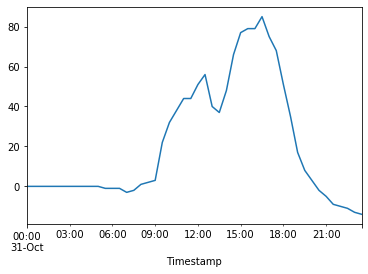

In [405]:
(joined
  .loc['2005-10-31', 'Net_cumulative']
  .plot())

## Resample

In [208]:
def resample_pivot(df_pivot, sampling='h'):
    
    return (df_pivot
            .resample(sampling)
            .agg({'In':'sum',
                  'Out': 'sum',
                  'Net':'sum',
                  'Date': 'last',
                  'Time': 'first'}))


df_hourly = resample_pivot(df_pivot, 'h')


In [ ]:
def hourly_with_confidence_bars():
    df_hourly = resample_pivot(df_pivot)
    df_g = (df_hourly
     .groupby('Time')
     .agg({'In':['mean', 'std']}))

    df_g.columns = df_g.columns.get_level_values(1)


    ax = df_g.plot(y='mean')

    ax.fill_between(df_g.index, 
                    df_g['mean']+df_g['std'],
                    df_g['mean']-df_g['std'],
                    alpha=0.3)

hourly_with_confidence_bars()



### Day of week

In [212]:
df_daily = resample_pivot(df_pivot, 'd')
df_weekdays = df_daily[df_daily['Date'].dt.dayofweek < 5]

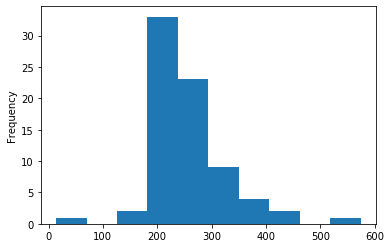

In [213]:
df_weekdays['In'].plot.hist()

In [341]:
df_pivot['Day'] = df_pivot['Date'].dt.dayofweek
df_dayofweek_mean = df_pivot.groupby(['Day', 'Time']).mean()

## By month

In [358]:

monthly = get_monthly(df_hourly).reset_index()
monthly['Month'] = monthly['Timestamp'].dt.month

monthly = monthly.set_index('Timestamp')

In [361]:
df_pivot

,In,Out,Net,Date,Time,Day
Timestamp,,,,,,
2005-07-24 00:00:00,0,0,0,2005-07-24,00:00:00,6
2005-07-24 00:30:00,0,1,-1,2005-07-24,00:30:00,6
2005-07-24 01:00:00,0,0,0,2005-07-24,01:00:00,6
2005-07-24 01:30:00,0,0,0,2005-07-24,01:30:00,6
2005-07-24 02:00:00,0,0,0,2005-07-24,02:00:00,6
...,...,...,...,...,...,...
2005-11-05 21:30:00,0,0,0,2005-11-05,21:30:00,5
2005-11-05 22:00:00,0,3,-3,2005-11-05,22:00:00,5
2005-11-05 22:30:00,0,0,0,2005-11-05,22:30:00,5


In [352]:
monthly

,In,Out,Net,Date,Time,Month
Timestamp,,,,,,
2005-07-24 00:00:00,0,1,-1,2005-07-24,00:00:00,7
2005-07-24 01:00:00,0,0,0,2005-07-24,01:00:00,7
2005-07-24 02:00:00,0,2,-2,2005-07-24,02:00:00,7
2005-07-24 03:00:00,0,0,0,2005-07-24,03:00:00,7
2005-07-24 04:00:00,0,0,0,2005-07-24,04:00:00,7
...,...,...,...,...,...,...
2005-11-05 19:00:00,0,3,-3,2005-11-05,19:00:00,11
2005-11-05 20:00:00,0,3,-3,2005-11-05,20:00:00,11
2005-11-05 21:00:00,0,0,0,2005-11-05,21:00:00,11


In [304]:
df_daily['Day'] = df_daily['Date'].dt.dayofweek

In [319]:
monthly_all = monthly.reset_index().groupby(['Month', 'Time']).agg({
    'In':'mean',
    'Out':'mean',
    'Net':'mean'
}).reset_index()

In [309]:
def get_avg_by_time(monthly_df, col='In'):
    
    monthly_in = monthly_df.loc[:, ]
    
    monthly_in_groups = monthly_in.reset_index().melt(id_vars='Timestamp').groupby('Timestamp').groups
    monthly_in_melt = monthly_in.reset_index().melt(id_vars='Timestamp')
    monthly_in_melt['Month'] = monthly_in_melt['Timestamp'].dt.month    
    monthly_in_melt['Time'] = monthly_in_melt['Timestamp'].dt.time  
    
    return monthly_in_melt.groupby(['Month', 'Time']).mean().reset_index().set_index('Time')

In [310]:
monthly_all = get_avg_by_time(monthly)

DataError: No numeric types to aggregate

In [ ]:
def get_month(month_ind):
    months = {
    7:'July',
    8:'August',
    9:'September',
    10:'October',
    11:'November'}
    
    return months[month_ind]


def get_day_of_week(dayofweek_ind):
    days = {
        0:'Monday',
        1:'Tuesday',
        2:'Wednesday',
        3:'Thursday',
        4:'Friday',
        5:'Saturday',
        6:'Sunday'}
    
    return days[dayofweek_ind]
    
    


""


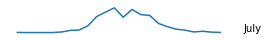

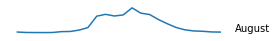

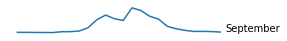

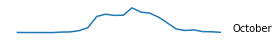

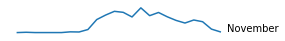

In [328]:
def month_sparkline(df, by='Month', col='In'):
    

    #fig, ax = plt.subplots(1,1,figsize=(4,.5));

    ax = df[[col]].plot(legend=None, figsize=(4,.5));

    month = get_month(df['Month'][0])


    # remove all the axes
    for k,v in ax.spines.items():
        v.set_visible(False)
    if month is not 'November':
        plt.xlabel('')


    ax.set_xticks([])
    ax.set_yticks([])
    #plt.axis('off')
    plt.xlabel('')

    plt.ylabel(month, rotation='horizontal', labelpad=0, size=10)
    ax.yaxis.set_label_coords(1.1, 0)
    
    return None
    
    
monthly_all.groupby('Month').apply(month_sparkline)

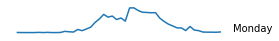

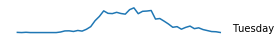

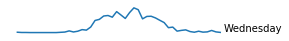

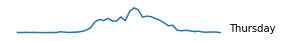

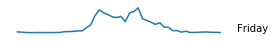

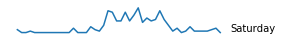

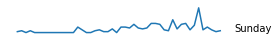

In [340]:

def sparkline(df, col='In', by='Day'):
   
    
    fig, ax = plt.subplots(1,1,figsize=(4,.5))

    df.plot(y=col, ax=ax, legend=None)

    ylabel = ''
    if by == 'Day':
        ylabel = get_day_of_week(df.reset_index()['Day'][0])
    if by == 'Month':
        ylabel = get_month(df['Month'][0])
        
    

    # remove all the axes
    for k,v in ax.spines.items():
        v.set_visible(False)
        
    ax.set_xticks([])
    ax.set_yticks([])
    #plt.axis('off')
    plt.xlabel('', rotation='horizontal', labelpad=0, size=10)

    plt.ylabel(ylabel, rotation='horizontal', labelpad=0, size=10)
    ax.yaxis.set_label_coords(1.1, 0)
    # remove legend
    
    
def sparklines(df, col='In', by='Day'):
    
    df.groupby(by).apply(lambda x: sparkline(x, col, by))
    
sparklines(df_dayofweek_mean)



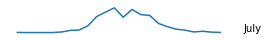

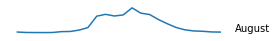

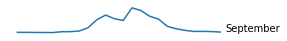

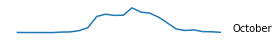

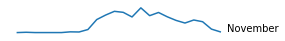

In [339]:
sparklines(monthly_all, col='In', by='Month')